In [143]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew, median_abs_deviation

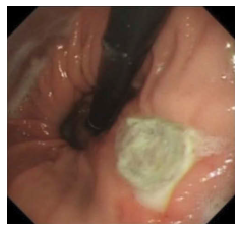

In [144]:
# Reading an image.
image =cv.imread('lesion.png',cv.IMREAD_COLOR)
imageHeight = image.shape[0]
imageWidth = image.shape[1]
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
# Displaying the image.
plt.axis('off')
plt.imshow(image)

In [145]:
# Getting the kernel to be used in Top-Hat and Bottom-Hat filters.
filterSize =(12, 12)
kernel = cv.getStructuringElement(cv.MORPH_RECT, filterSize)
# Structring elements : MORPH_ELLIPSE, MORPH_CROSS, MORPH_RECT 

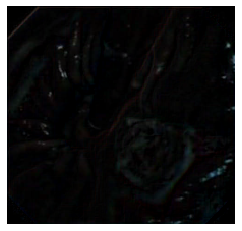

In [146]:
# Applying the Top-Hat operation.
tophat_img = cv.morphologyEx(image, cv.MORPH_TOPHAT, kernel)
plt.axis('off')
plt.imshow(tophat_img)

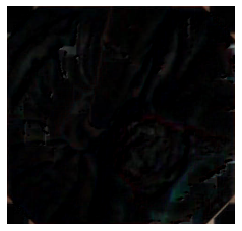

In [147]:
# Applying the Bottom-Hat operation.
bottomhat_img = cv.morphologyEx(image, cv.MORPH_BLACKHAT, kernel)
plt.axis('off')
plt.imshow(bottomhat_img)

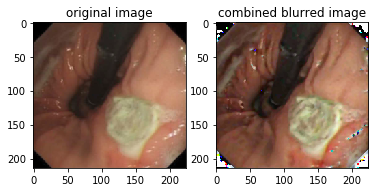

In [148]:
# Combining the TOP-BOTTOM hat and the original image.
comb_img = tophat_img + image - bottomhat_img
# Applying a 3*3 median filter to the combined image.
blurredImage = cv.medianBlur(comb_img,3)
# Displaying the image after applying the median filter.
plt.subplot(121);plt.title('original image');plt.imshow(image)
plt.subplot(122);plt.title('combined blurred image');plt.imshow(blurredImage)

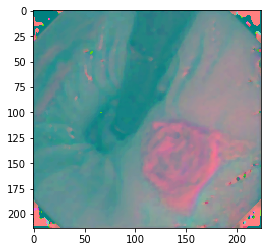

In [149]:
# Converting the RGB image into L*A*b* image.
labBlurredImage = cv.cvtColor(blurredImage, cv.COLOR_RGB2Lab)
# Extracting color parameters.
l = labBlurredImage[:,:,0]
a = labBlurredImage[:,:,1]
b = labBlurredImage[:,:,2]
plt.imshow(labBlurredImage)


In [150]:
# Calculating the L*a*b* image's mean, variance and standard deviation.
lMean, lStd = cv.meanStdDev(l); lMean, lStd = lMean[0,0], lStd[0,0]; lVariance = lStd **2
aMean, aStd = cv.meanStdDev(a); aMean, aStd = aMean[0,0], aStd[0,0]; aVariance = aStd **2
bMean, bStd = cv.meanStdDev(b); bMean, bStd = bMean[0,0], bStd[0,0]; bVariance = bStd **2
print('Means: ',lMean, aMean, bMean,'\nStds: ',lStd, aStd, bStd,'\nVariance: ',lVariance,aVariance,bVariance,'\n')

Means:  106.6336782376502 140.52736982643523 144.5989444259012 
Stds:  52.42271422686119 10.074923854748842 9.284343277477298 
Variance:  2748.1409669111545 101.50409067898727 86.1990300940379 



In [151]:
# Calculating kurtosis, skewness
lKurtosis = kurtosis(l, axis=None); lSkewness = skew(l, axis=None)
aKurtosis = kurtosis(a, axis=None); aSkewness = skew(a, axis=None)
bKurtosis = kurtosis(b, axis=None); bSkewness = skew(b, axis=None)
print('Kurtosis: ',lKurtosis, aKurtosis, bKurtosis,'\nSkewness',lSkewness,aSkewness,bSkewness)

Kurtosis:  -0.38103456797104274 6.064125590589885 25.9007051579429 
Skewness 0.25724153377587433 -0.08212348311622156 -1.8965141628300977


In [152]:
# Fused Vector.
fusedVector = [lMean+aMean+bMean, lStd+aStd+bStd, lVariance+aVariance+bVariance]
for i in range(0,imageHeight):
    fusedVector.append(kurtosis(l[i], axis=None)+kurtosis(a[i], axis=None)+kurtosis(b[i], axis=None))
    fusedVector.append(skew(l[i], axis=None)+skew(a[i], axis=None)+skew(b[i], axis=None))
fusedVector = np.array(fusedVector)
print('fused vector :\n',fusedVector)

fused vector :
 [ 3.91759992e+02  7.17819814e+01  2.93584409e+03  6.23637353e+00
  2.41289022e+00  1.96686438e+01  3.75649870e+00  1.82361367e+01
  5.04004541e+00  4.50867708e+01  1.21593679e+00  1.70337552e+01
  4.74729031e+00  3.79143381e+01  2.79584281e+00  4.19770202e+01
  2.80785275e+00  6.64720296e+01 -1.20379658e+00  5.56786269e+01
  3.48975959e-01  5.80743963e+01  2.57945870e-01  1.63480835e+00
  1.72094785e+00  5.48332345e+01 -9.06620576e-03  2.31080491e+01
  4.06993310e+00  5.08490361e+01 -2.03590466e-01  6.00736163e+01
 -2.20959712e+00  6.13350852e+01 -3.74836007e+00  6.58987733e+00
 -1.46115174e+00 -3.38503846e+00 -5.20553495e-01  1.10239407e-01
  3.43650252e-01  1.96214780e+00  7.96181471e-01  2.08975838e+00
  7.06140943e-01  2.94476296e+01  4.83794198e+00  5.14076706e+01
  4.60830681e-01  5.64644194e+01  7.07194094e-01  2.50619380e+01
  2.56121717e+00  1.56946053e+01 -2.12584587e+00  3.46748565e+01
 -3.71101625e+00  2.86873670e+01 -2.07030044e+00  4.55168314e+00
 -7.14383

In [153]:
# MD
md = np.mean(np.absolute(fusedVector - np.mean(fusedVector)))
print('MD :\n',md)

MD :
 21.559472858929976


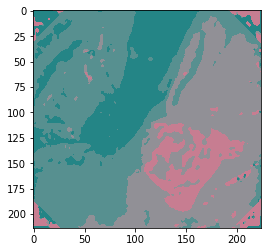

In [154]:
# Clustering with K-means algorithm.
# Reshape the image to a 2D array of pixels and 3 color values (L*A*B*).
pixelValues = labBlurredImage.reshape((-1, 3))
# Convert to float.
pixelValues = np.float32(pixelValues)
# Define stopping criteria.
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2)
# Number of clusters (K).
k = 4
_, labels, (centers) = cv.kmeans(pixelValues, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

# Convert back to 8 bit values
centers = np.uint8(centers)

# Flatten the labels array
labels = labels.flatten()

# Convert all pixels to the color of the centroids.
segmentedImage = centers[labels.flatten()]

# Reshape back to the original image dimension.
segmentedImage = segmentedImage.reshape(image.shape)
plt.imshow(segmentedImage)
plt.show()


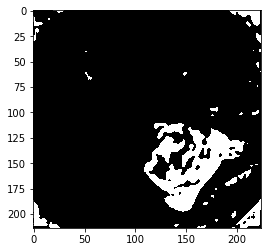

In [155]:
# Thresholding the image.
newL = segmentedImage[:,:,0]
newA = segmentedImage[:,:,1]
newB = segmentedImage[:,:,2]
thres_image = np.zeros((imageHeight,imageWidth))
for i in range(0,imageHeight):
    for j in range(0,imageWidth):
        if(newL[i,j] >= 180):
            thres_image[i,j] = 255
plt.imshow(thres_image, cmap='gray')

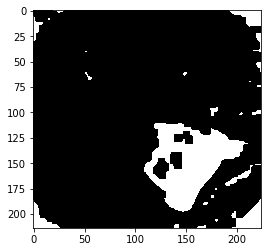

In [156]:
# refining the thres_image.
kernelR = np.ones((7,7),np.uint8)
# dilatedImage = cv.dilate(thres_image,kernel,iterations = 1)
refinedImage = cv.morphologyEx(thres_image, cv.MORPH_CLOSE, kernelR)
plt.imshow(refinedImage, cmap='gray')